In [1]:
import torch
from torch import nn ##nn contains all the buiding block needed to work with neural networks
import matplotlib.pyplot as plt
torch.__version__

'2.3.0+cu121'

## Preparing and loading data

### Linear Regression
For now we are going to create our own data(points on a simple linear line) and then build a model to predict the weight(slope) and bias(intercept) for that dataset

In [2]:
# these are the values we are going to predict later
weight = 0.3
bias = 0.7

In [3]:
#dataset creation
X = torch.arange(0,10,0.02).unsqueeze(dim=1) #unsqueezing converts it into a tensor
y = X*weight + bias

In [4]:
#train-test-splitting
train_size = int(0.8*len(X))
x_train, x_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

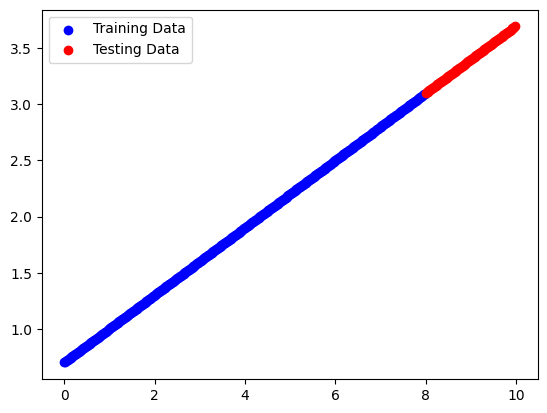

In [5]:
#Data Visualization
plt.scatter(x_train, y_train, color="blue", label="Training Data")
plt.scatter(x_test, y_test, color="red", label="Testing Data")
plt.legend()

In [6]:
#Writing the linear regression class

class LinearRegression(nn.Module):  #our class inherits from nn.Module
    def __init__(self):   ##python syntax
        super().__init__()
        torch.manual_seed(40) #to get consistent results
        self.weight = nn.Parameter(torch.randn(1, requires_grad=True))
        torch.manual_seed(40) #to get consistent results
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True))
        
#creates a random parameter(size=1) which is a random number to be used as weight/bias in
#the starting, requires_grad=True means torch will keep a track of the gradient
#to help us use gradient descent by updating the values

    #forward method to define the computation in the model.
    def forward(self, x: torch.Tensor) -> torch.Tensor:  #this is the syntax to tell the input and return type
        return self.weight * x + self.bias

# Pytorch Model Building Essentials
* torch.nn - contains all the buildings for computational graphs(neural network)
* torch.nn.Parameter - what params should our model try and learn, often a pytorch layer from torch.nn will set these for us.
* torch.nn.Module - The base class for all neural network modules, if you subclass it, you need to override the forward() method.
* torch.optim - this is where the optimizers in pytorch live, they will help with gradient descent.
* def forward() - All nn.Module subclasses require you to overwrite forward(), this method defines what happens in the forward computation. 

## Looking whats inside our Model....
We can look at the parameters using `.parameters()` method

In [7]:
model = LinearRegression() #created an instance of the class
list(model.parameters())

[Parameter containing:
 tensor([0.9307], requires_grad=True),
 Parameter containing:
 tensor([0.9307], requires_grad=True)]

In [8]:
model.state_dict()   #gies out a dictionary of params

OrderedDict([('weight', tensor([0.9307])), ('bias', tensor([0.9307]))])

### Making predictions using `torch.inference_mode()`
To check the predictive power of our model, we run x_test through the model and compare it to y_test
When we pass the data through our model, it is going to run through the forward() method.

When we use inference_mode(), we do not track gradient because we not training the data, rather we are checking it, infact we disable all the things that we need while training data. 

When dealing with large data, we use inference_mode while predicting as it is much faster as it saves memory.

In [9]:
with torch.inference_mode():
    y_preds = model(x_test)

print(y_preds[:10])
print(y_test[:10])    #the values are very off because the model is not trained

tensor([[8.3764],
        [8.3950],
        [8.4137],
        [8.4323],
        [8.4509],
        [8.4695],
        [8.4881],
        [8.5067],
        [8.5253],
        [8.5440]])
tensor([[3.1000],
        [3.1060],
        [3.1120],
        [3.1180],
        [3.1240],
        [3.1300],
        [3.1360],
        [3.1420],
        [3.1480],
        [3.1540]])


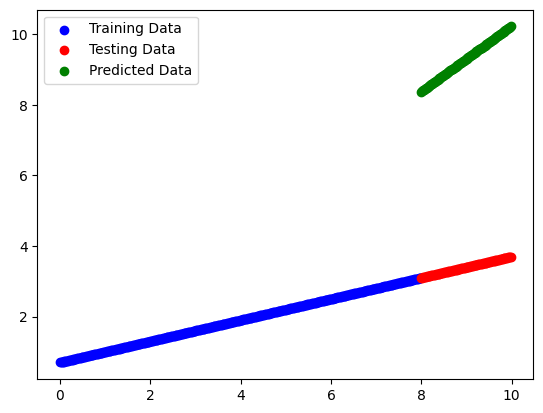

In [10]:
plt.scatter(x_train, y_train, color="blue", label="Training Data")
plt.scatter(x_test, y_test, color="red", label="Testing Data")
plt.scatter(x_test, y_preds, color="green", label="Predicted Data")
plt.legend()

### Predicting without `torch.inference_mode()`
This tracks the gradient and we can see that when we print the predicted values, it shows `grad_fn`.

In [11]:
y_preds = model(x_test)  #as simple as that
y_preds[:10]

tensor([[8.3764],
        [8.3950],
        [8.4137],
        [8.4323],
        [8.4509],
        [8.4695],
        [8.4881],
        [8.5067],
        [8.5253],
        [8.5440]], grad_fn=<SliceBackward0>)

## Training Our Model
Training basically means optimizing the values of the parameters to best fit the data or simply minimizing the error. To keep a track of errors, we use a loss function. Pytorch has a lot of builtin loss functions. 
Loss function may be known with different names like cost function or criterion in different areas.
* **Loss Function** - a function that calculates how off are the predicted values are from the real values.
* **Optimizer** - a function that takes into account the loss function and acts upon the parameters to reduce the loss function.
We can look at mulitple loss functions and optimizer on torch's website and use the best for our use case.

In [12]:
#picking up the loss function
loss_fn = nn.L1Loss() #this is the mean abs error func just named by their conventions mehhhh

#picking up an optimizier
optimizer = torch.optim.SGD(params = model.parameters(), lr = 0.01) #stochastic graident descent
# lr stands for the learning rate and determines how large steps are being taken by the optimizer

### Training Loop 
* 1) Loop through data
  2) Forward Propogation - passes data through our `forward()` function to make predictions.
  3) Calcluate the loss- How off is the real data from predicted data.
  4) Optimizer zero grad
  5) Backpropogation- Move back through the network to calculate the gradient of each parameter wrt to the loss function.
  6) Optimizer step- use the optimizer algo to reduce the loss.

In [13]:
torch.manual_seed(42) #to get consistent results
#an epoch is one loop through data
epochs = 160

### Training Mode
# 0. Loop through data
for epoch in range(epochs):
    #set the model to training mode
    model.train() #sets all params that require gradients to require graidents

    # 1. Forward Pass 
    y_preds = model(x_train)

    # 2. Calculating loss
    loss = loss_fn(y_preds, y_train)

    # 3. Optimizer zero grad
    optimizer.zero_grad()  #zeroes the optimizer step value.

    # 4. Backpropogation
    loss.backward()

    # 5. Optimizer optimizes parameters
    optimizer.step()  #calculates what step to take(suppose a step of +1), it need to be zeroed before the next iteration so that next step can be calculated otherwise the steps will keep piling up 

###Testing Mode
    model.eval()  # turns off all settings of the model not needed for evaluation/testing
    with torch.inference_mode():  # turns off gradient tracking
        # 1. Do the forward pass
        test_preds = model(x_test)

        # 2. Calculate the loss
        test_loss = loss_fn(test_preds, y_test)
    if(epoch%10==0):
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss} ")
        print(model.state_dict())


Epoch: 0 | Train loss: 2.7472622394561768 | Test loss: 5.532130718231201 
OrderedDict({'weight': tensor([0.8908]), 'bias': tensor([0.9207])})
Epoch: 10 | Train loss: 1.055252194404602 | Test loss: 1.8451201915740967 
OrderedDict({'weight': tensor([0.4918]), 'bias': tensor([0.8207])})
Epoch: 20 | Train loss: 0.0841454491019249 | Test loss: 0.26070675253868103 
OrderedDict({'weight': tensor([0.2649]), 'bias': tensor([0.7551])})
Epoch: 30 | Train loss: 0.03011612594127655 | Test loss: 0.36308109760284424 
OrderedDict({'weight': tensor([0.2552]), 'bias': tensor([0.7397])})
Epoch: 40 | Train loss: 0.07519307732582092 | Test loss: 0.2475443035364151 
OrderedDict({'weight': tensor([0.2693]), 'bias': tensor([0.7285])})
Epoch: 50 | Train loss: 0.05114318057894707 | Test loss: 0.28976455330848694 
OrderedDict({'weight': tensor([0.2657]), 'bias': tensor([0.7190])})
Epoch: 60 | Train loss: 0.03955704718828201 | Test loss: 0.30835092067718506 
OrderedDict({'weight': tensor([0.2643]), 'bias': tensor

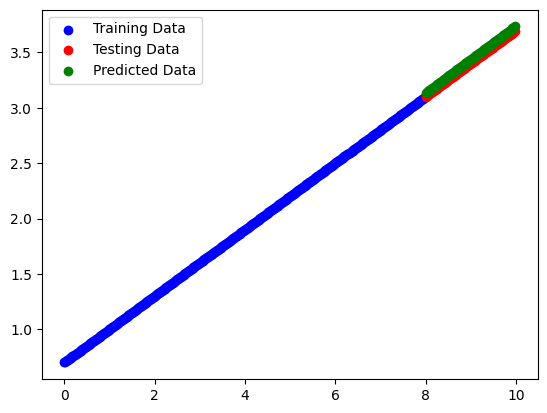

In [14]:
with torch.inference_mode():
    y_preds = model(x_test)
    plt.scatter(x_train, y_train, color="blue", label="Training Data")
    plt.scatter(x_test, y_test, color="red", label="Testing Data")
    plt.scatter(x_test, y_preds, color="green", label="Predicted Data")
    plt.legend()

## Building the model using `nn.Linear()`
Now we will not define the parameters ourselves rather create a network which already has the parameters weights and biases already in it. We just need to create layers.

In [26]:
#Creating Data
X = torch.arange(0,10,0.02, device = 'cuda').unsqueeze(dim=1) #unsqueezing converts it into a tensor
y = X*weight + bias
#train-test-splitting
train_size = int(0.8*len(X))
x_train, x_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [34]:
#Model Creation
class LinearRegressionV2(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(42)
        self.linear_layer = nn.Linear(in_features=1, out_features =1) #in/out_features are the no. of nodes in input and output layers.
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

In [35]:
model1 = LinearRegressionV2()
model1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
             ('linear_layer.bias', tensor([0.8300]))])

In [36]:
next(model1.parameters()).device #checking where the model is

device(type='cpu')

In [37]:
model1.to('cuda') #transferring it to the gpu
next(model1.parameters()).device

device(type='cuda', index=0)

In [38]:
#Loss function and Optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params = model1.parameters(), lr = 0.01)

In [40]:
#Training
epochs = 50
for epoch in range(epochs):
    model1.train()
    preds = model1(x_train)
    loss = loss_fn(preds, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

#Testing
    model1.eval()
    with torch.inference_mode():
        test_preds = model1(x_test)
        test_loss = loss_fn(test_preds, y_test)
    if(epoch%10==0):
        print(f"Epoch: {epoch} | TrainLoss: {loss} | TestLoss: {test_loss}")
        print(model1.state_dict())

Epoch: 0 | TrainLoss: 0.06406950205564499 | TestLoss: 0.22436504065990448
OrderedDict({'linear_layer.weight': tensor([[0.3238]], device='cuda:0'), 'linear_layer.bias': tensor([0.7100], device='cuda:0')})
Epoch: 10 | TrainLoss: 0.06406950205564499 | TestLoss: 0.22436504065990448
OrderedDict({'linear_layer.weight': tensor([[0.3238]], device='cuda:0'), 'linear_layer.bias': tensor([0.7100], device='cuda:0')})
Epoch: 20 | TrainLoss: 0.06406950205564499 | TestLoss: 0.22436504065990448
OrderedDict({'linear_layer.weight': tensor([[0.3238]], device='cuda:0'), 'linear_layer.bias': tensor([0.7100], device='cuda:0')})
Epoch: 30 | TrainLoss: 0.06406950205564499 | TestLoss: 0.22436504065990448
OrderedDict({'linear_layer.weight': tensor([[0.3238]], device='cuda:0'), 'linear_layer.bias': tensor([0.7100], device='cuda:0')})
Epoch: 40 | TrainLoss: 0.06406950205564499 | TestLoss: 0.22436504065990448
OrderedDict({'linear_layer.weight': tensor([[0.3238]], device='cuda:0'), 'linear_layer.bias': tensor([0.71